In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [4]:
# Usaremos la base de datos: Beijing Multi-Site Air-Quality Data Data Set,
# la cual puede ser obtenida desde https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data
# (revisar la página para más detalles sobre los datos)
# Se ha proporcionado un archivo csv con la información obtenida de la estación
# de monitoreo Aotizhongxin, el cual contiene 35,064 registros.

# El objetivo es poder predecir la concetración de PM2.5 y de PM10 a partir de las
# variables año, mes, día, hora, temperatura, presión, punto de rocío, 
# precipitación y velocidad del viento.

# Part 1: Load data into Colab

# Requiered to select a file from your HD
from google.colab import files
uploaded = files.upload()

In [5]:
from my_path import my_path

In [6]:
# Import file and store it in a data frame
df = pd.read_csv(my_path + '/PRSA_Aotizhongxin.csv') # Cambia al nombre del archivo que cargues
df.dropna(inplace=True)
df
# Quedan 31,815 registros despues de eliminar NaN's

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,2017,2,28,19,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,NW,2.4,Aotizhongxin
35060,35061,2017,2,28,20,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Aotizhongxin
35061,35062,2017,2,28,21,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,NW,1.1,Aotizhongxin
35062,35063,2017,2,28,22,21.0,44.0,12.0,87.0,700.0,35.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Aotizhongxin


# Part 2: Format data and split it into numpy arrays

In [16]:
# AUX function to put categorical data into one-hot encoding format
def winddir_to_categorical(winddir):
  enc = OneHotEncoder(sparse=False)
  WD = enc.fit_transform(winddir)
  print("== categories:", enc.categories_, "==")
  return WD, [item for sublist in enc.categories_ for item in sublist]

== categories: [array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
       'SSW', 'SW', 'W', 'WNW', 'WSW'], dtype=object)] ==
Input values X with shape (31815, 28). With values


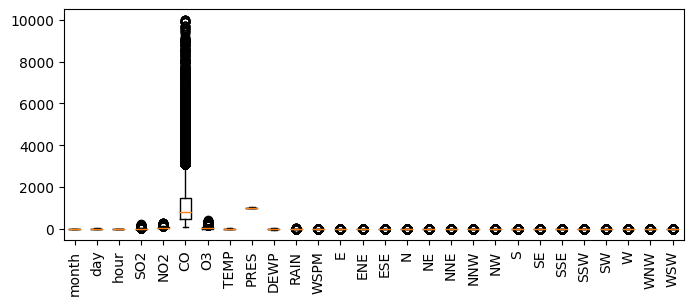

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,31815.000000,31815.000000,31815.000000,31815.000000,31815.000000,31815.000000,31815.000000,31815.000000,31815.000000,31815.000000,...,31815.000000,31815.000000,31815.000000,31815.000000,31815.000000,31815.000000,31815.000000,31815.000000,31815.0000,31815.000000
mean,6.401886,15.578564,11.624800,17.167205,58.976332,1256.574729,56.240938,13.775611,1011.800385,3.241106,...,0.044507,0.053748,0.038158,0.039101,0.029672,0.060349,0.095772,0.033601,0.0314,0.062706
std,3.416847,8.794954,6.926874,22.760801,37.061384,1223.301208,57.834314,11.369035,10.338869,13.667863,...,0.206223,0.225524,0.191581,0.193838,0.169682,0.238136,0.294284,0.180201,0.1744,0.242438
min,1.000000,1.000000,0.000000,0.571200,2.000000,100.000000,0.214200,-16.800000,985.900000,-35.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
25%,3.000000,8.000000,6.000000,3.000000,30.000000,500.000000,8.000000,3.400000,1003.300000,-8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
50%,6.000000,15.000000,12.000000,8.000000,53.000000,800.000000,42.000000,14.800000,1011.200000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
75%,9.000000,23.000000,18.000000,21.000000,82.000000,1500.000000,82.000000,23.400000,1020.000000,15.700000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
max,12.000000,31.000000,23.000000,229.000000,290.000000,10000.000000,423.000000,40.500000,1042.000000,28.500000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000


In [17]:
# Extract input features and convert them to a numpy array
labels = ['month',	'day',	'hour', 'SO2',	'NO2',	'CO',	'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM' ]
X = df[labels].to_numpy()
WD, categories = winddir_to_categorical(df[['wd']])
X = np.concatenate((X, WD), axis=1)

print(f"Input values X with shape {X.shape}. With values")

plt.figure(figsize=(8, 3))
plt.boxplot(X)
plt.xticks(range(1, 29), labels + categories, rotation=90)
plt.show()

pd.DataFrame(X).describe()

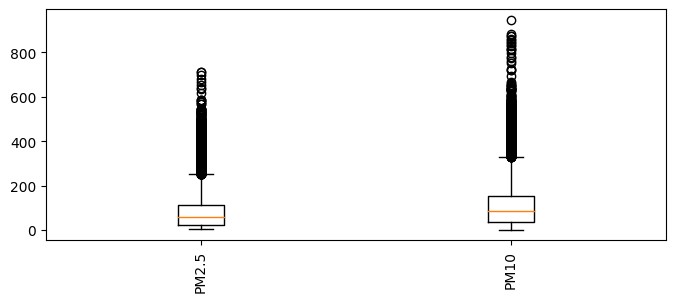

,0,1
count,31815.00000,31815.000000
mean,81.86363,109.120685
std,80.44949,93.718017
min,3.00000,2.000000
25%,22.00000,37.000000
50%,58.00000,86.000000
75%,114.00000,154.000000
max,713.00000,948.000000


In [18]:
# Extract output features and convert them to a numpy array
Y = df[['PM2.5', 'PM10']].to_numpy()

plt.figure(figsize=(8, 3))
plt.boxplot(Y)
plt.xticks(range(1, 3), ['PM2.5', 'PM10'], rotation=90)
plt.show()

pd.DataFrame(Y).describe()

In [19]:
# Split data into train+val and test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(28633, 28)
(28633, 2)
(3182, 28)
(3182, 2)


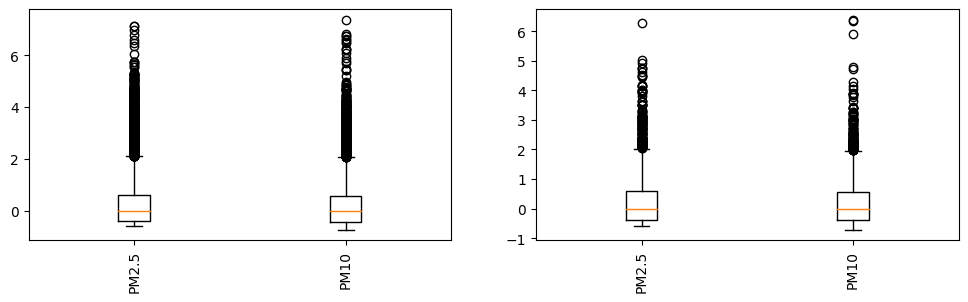

,0,1
count,28633.000000,28633.000000
mean,0.260684,0.198141
std,0.876474,0.801230
min,-0.597826,-0.717949
25%,-0.391304,-0.418803
50%,0.000000,0.000000
75%,0.608696,0.581197
max,7.119565,7.367521


In [20]:
# Normalize (zero-center) and standardize (scale) output data
scalerY = RobustScaler()
y_train = scalerY.fit_transform(y_train)
y_test = scalerY.transform(y_test)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.boxplot(y_train)
plt.xticks(range(1, 3), ['PM2.5', 'PM10'], rotation=90)
plt.subplot(1, 2, 2)
plt.boxplot(y_test)
plt.xticks(range(1, 3), ['PM2.5', 'PM10'], rotation=90)
plt.show()

pd.DataFrame(y_train).describe()

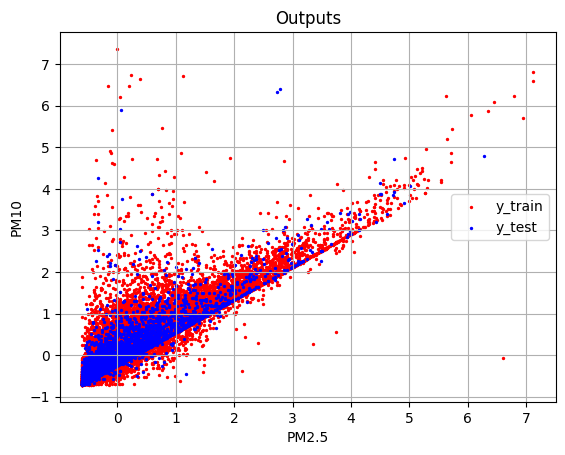

In [21]:
# Plot y_test
# Esta gráfica es para ver sólo si los sets de entrenamiento y test cubren las mismas
# áreas (¿tienen la misma distribución?). No se espera que los puntos coincidan ya que
# son dos sets distintos.
plt.scatter(y_train[:, 0], y_train[:, 1], c='r', s=2, label='y_train')
plt.scatter(y_test[:, 0], y_test[:, 1], c='b', s=2, label='y_test')

plt.legend()
plt.grid(True)
plt.xlabel('PM2.5')
plt.ylabel('PM10')
plt.title('Outputs')
plt.show()

# Part 3: Create DNN models and train them

In [22]:
# https://www.youtube.com/watch?v=Z9lQ1hzJFe8
# https://www.youtube.com/watch?v=Lx16T9cl5ng
# https://github.com/krishnaik06/Keras-Tuner/blob/main/Hidden%20Layers%20And%20Hidden%20Neurons.ipynb
# https://www.tensorflow.org/tutorials/keras/keras_tuner
# https://keras.io/keras_tuner/
# https://keras.io/guides/keras_tuner/getting_started/
# https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html?_gl=1*1kyglir*_ga*NDE3NTA3MzMzLjE2Njg1MzgxMDc.*_ga_W0YLR4190T*MTY3NDQ5MjM3OC42LjEuMTY3NDQ5MjY3MC4wLjAuMA..
# https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams
# https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f

In [23]:
!pip install -q -U keras-tuner

In [24]:
# tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.optimizers import Adam

import keras_tuner as kt
from keras_tuner.tuners import RandomSearch

# Part 3.1: DNN with custom functions

In [25]:
# Create a Deep Network
DNN = Sequential()
DNN.add(InputLayer(input_shape=x_train.shape[1:], name='INPUT'))

DNN.add(Dense(units=1024, activation='relu'))
DNN.add(Dense(units=512, activation='relu'))
DNN.add(Dense(units=256, activation='relu'))

DNN.add(Dense(units=y_train.shape[1], activation='linear', name='OUTPUT'))

DNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              29696     
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 OUTPUT (Dense)              (None, 2)                 514       
                                                                 
Total params: 686,338
Trainable params: 686,338
Non-trainable params: 0
_________________________________________________________________


In [26]:
def r_square(y, y_hat):
  """ Define R square loss, to use it as metric during training
  """
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_hat)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  return tf.subtract(1.0, residual / total)

In [27]:
def my_mse(y, y_hat):
  """ Define MSE loss, to use it as loss function
  """
  return tf.reduce_mean(tf.square(y - y_hat))

In [28]:
# Define training parameters
# Option 1: Usar un optimizador predefinido, pero con hyperparams no estándar
#from tensorflow.keras.optimizers import SGD
#sgd = SGD(learning_rate=0.02, momentum=0.6)
#DNN.compile(optimizer=sgd, loss='mse')

# Option 2: Usar optimizador predefinido, con una pérdida custom, e incluir otras
# métricas de monitoreo
DNN.compile(optimizer='adam', loss=my_mse, metrics=['mape', r_square])

# Try with different optimizers
#DNN.compile(optimizer=???, loss='mse')

In [29]:
# Train model
H = DNN.fit(x=x_train, y=y_train, batch_size=128, epochs=30, validation_split=0.1)

Epoch 1/30
202/202 [==============================] - 2s 8ms/step - loss: 447.0455 - mape: 26827052.0000 - r_square: -648.0632 - val_loss: 0.4130 - val_mape: 1591230.8750 - val_r_square: 0.4238
Epoch 2/30
202/202 [==============================] - 1s 6ms/step - loss: 0.6703 - mape: 2284818.7500 - r_square: 0.0149 - val_loss: 0.3733 - val_mape: 1397695.2500 - val_r_square: 0.4859
Epoch 3/30
202/202 [==============================] - 1s 6ms/step - loss: 3.0271 - mape: 3867530.7500 - r_square: -3.6617 - val_loss: 34.3850 - val_mape: 8457452.0000 - val_r_square: -46.9982
Epoch 4/30
202/202 [==============================] - 1s 7ms/step - loss: 13.8558 - mape: 5926636.0000 - r_square: -20.0160 - val_loss: 0.2798 - val_mape: 1491088.1250 - val_r_square: 0.6162
Epoch 5/30
202/202 [==============================] - 1s 6ms/step - loss: 0.2507 - mape: 1439163.8750 - r_square: 0.6390 - val_loss: 0.2577 - val_mape: 1330523.7500 - val_r_square: 0.6448
Epoch 6/30
202/202 [===========================

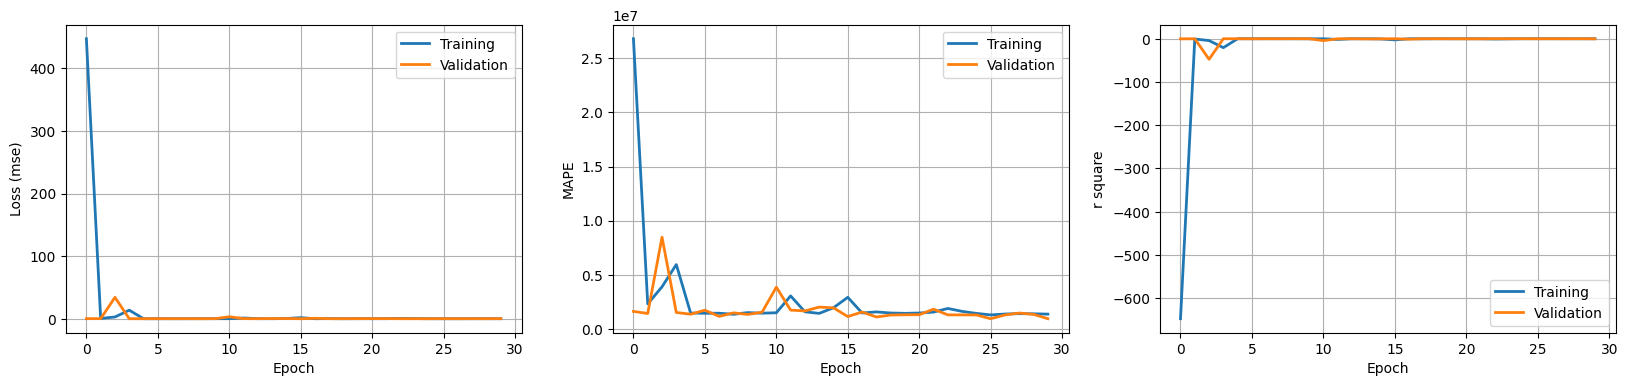

In [30]:
# Plot loss
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
plt.plot(DNN.history.history['loss'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (mse)')
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(DNN.history.history['mape'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_mape'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.grid()
plt.subplot(1, 3, 3)
plt.plot(DNN.history.history['r_square'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_r_square'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('r square')
plt.grid()
plt.show()

In [31]:
# Compute test loss
loss_test = DNN.evaluate(x=x_test, y=y_test, verbose=False)
print("Test loss, MAPE, and r2:", loss_test)

Test loss, MAPE, and r2: [0.3580520749092102, 897404.375, 0.442425012588501]


In [32]:
# Predict on test set
y_test_hat = DNN.predict(x=x_test)
print(y_test_hat.shape)

100/100 [==============================] - 0s 2ms/step
(3182, 2)


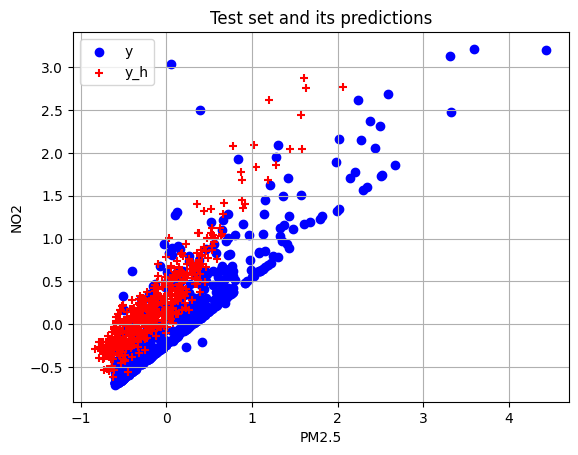

In [33]:
# Plot y_test_hat
indx = np.random.permutation(len(y_test))[:500]
plt.scatter(y_test[indx, 0], y_test[indx, 1], c='b', label='y')
plt.scatter(y_test_hat[indx, 0], y_test_hat[indx, 1], c='r', marker='+', label='y_h')

plt.legend()
plt.grid(True)
plt.xlabel('PM2.5')
plt.ylabel('NO2')
plt.title('Test set and its predictions')
plt.show()

# 3.2 Auto tuning of hyperparams: number of units and optimizer

In [34]:
def model_builder(hp):
  ''' Define a auxiliar function to create DNN models with varying
      hyperparameters.
  '''
  model = Sequential()
  model.add(InputLayer(input_shape=x_train.shape[1:], name='INPUT'))

  # Choose an optimal number of units for the unique hidden layer between 64-1024
  hp_units = hp.Int('units', min_value=64, max_value=1024, step=64)
  model.add(Dense(units=hp_units, activation='relu'))
  # Add output layer
  model.add(Dense(units=y_train.shape[1], name='OUTPUT'))

  # Choose best optimizer
  model.compile(optimizer=hp.Choice('optimizer', values=['sgd', 'adam', 'adagrad', 'adadelta']), loss='mse', metrics=['mape'])
  
  return model

In [35]:
# Create a tuner and show the search space
tuner = RandomSearch(model_builder,
                     objective='val_loss',
                     max_trials=32)

tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 64, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'sgd', 'conditions': [], 'values': ['sgd', 'adam', 'adagrad', 'adadelta'], 'ordered': False}


In [36]:
# Make an initial quick exploration of the hyperparam space
tuner.search(x_train, y_train, epochs=10, validation_split=0.1)

Trial 32 Complete [00h 00m 39s]
val_loss: 2.2898507118225098

Best val_loss So Far: 0.2763548791408539
Total elapsed time: 00h 17m 22s
INFO:tensorflow:Oracle triggered exit


In [37]:
# Get the top model
best_models = tuner.get_best_models()
best_model = best_models[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              29696     
                                                                 
 OUTPUT (Dense)              (None, 2)                 2050      
                                                                 
Total params: 31,746
Trainable params: 31,746
Non-trainable params: 0
_________________________________________________________________


In [38]:
# See top best results
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 1024
optimizer: adagrad
Score: 0.2763548791408539
Trial summary
Hyperparameters:
units: 768
optimizer: adagrad
Score: 0.2770603895187378
Trial summary
Hyperparameters:
units: 704
optimizer: adam
Score: 0.27882277965545654
Trial summary
Hyperparameters:
units: 960
optimizer: adagrad
Score: 0.28226354718208313
Trial summary
Hyperparameters:
units: 832
optimizer: adagrad
Score: 0.29469436407089233
Trial summary
Hyperparameters:
units: 896
optimizer: adagrad
Score: 0.30268627405166626
Trial summary
Hyperparameters:
units: 704
optimizer: adagrad
Score: 0.3316324055194855
Trial summary
Hyperparameters:
units: 640
optimizer: adam
Score: 0.3477030396461487
Trial summary
Hyperparameters:
units: 896
optimizer: adam
Score: 0.36334317922592163
Trial summary
Hyperparameters:
units: 576
optimizer: adagrad
Score: 0.40574201941490173


In [39]:
# Retrieve the best combination of hyperparams
best_hps = tuner.get_best_hyperparameters()[0]
best_hps.values

{'units': 1024, 'optimizer': 'adagrad'}

In [40]:
# Create a new model using the best hyperparams
DNN = model_builder(best_hps)
DNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1024)              29696     
                                                                 
 OUTPUT (Dense)              (None, 2)                 2050      
                                                                 
Total params: 31,746
Trainable params: 31,746
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Full training of best model
H = DNN.fit(x=x_train, y=y_train, batch_size=64, epochs=100, validation_split=0.1)

Epoch 1/100
403/403 [==============================] - 3s 5ms/step - loss: 13.5610 - mape: 5410594.0000 - val_loss: 0.6144 - val_mape: 2215672.0000
Epoch 2/100
403/403 [==============================] - 2s 5ms/step - loss: 0.5608 - mape: 2476195.5000 - val_loss: 0.5493 - val_mape: 1435609.3750
Epoch 3/100
403/403 [==============================] - 2s 5ms/step - loss: 0.4273 - mape: 2057375.5000 - val_loss: 0.4118 - val_mape: 1547701.5000
Epoch 4/100
403/403 [==============================] - 2s 5ms/step - loss: 0.3589 - mape: 1917438.3750 - val_loss: 0.3997 - val_mape: 1829018.8750
Epoch 5/100
403/403 [==============================] - 2s 5ms/step - loss: 0.3342 - mape: 1765739.2500 - val_loss: 0.3244 - val_mape: 1344558.8750
Epoch 6/100
403/403 [==============================] - 2s 5ms/step - loss: 0.3163 - mape: 1679705.1250 - val_loss: 0.3572 - val_mape: 1626185.5000
Epoch 7/100
403/403 [==============================] - 2s 5ms/step - loss: 0.3021 - mape: 1650282.8750 - val_loss: 0.

# 3.2 Auto tuning of hyperparams: number of layers, number of units, and optimizer

In [42]:
def model_builder(hp):
  ''' Define a auxiliar function to create DNN models with varying
      hyperparameters.
  '''
  model = Sequential()
  model.add(InputLayer(input_shape=x_train.shape[1:], name='INPUT'))

  # Choose optimal number of layers between 2 and 8
  for i in range(hp.Int('num_layers', 2, 8)):
    # Tune the number of units in the each dense layer
    hp_units = hp.Int('units_'+str(i), min_value=64, max_value=1024, step=64)
    model.add(Dense(units=hp_units, activation='relu'))
  # Add output layer
  model.add(Dense(units=y_train.shape[1], name='OUTPUT'))

  # Choose best optimizer
  model.compile(optimizer=hp.Choice('optimizer', values=['sgd', 'adam', 'adagrad', 'adadelta']), loss='mse', metrics=['mape'])
  
  return model

In [43]:
def model_builder(hp):
  model = Sequential()
  model.add(InputLayer(input_shape=x_train.shape[1:], name='INPUT'))

  # Choose an optimal number of units between 64-1024
  #hp_units = hp.Int('units', min_value=64, max_value=1024, step=64)
  # Choose optimal number of layers between 2 and 8
  for i in range(hp.Int('layers', 2, 8)):
    model.add(Dense(units=hp.Int('units_' + str(i), min_value=64, max_value=1024, step=64), activation='relu'))
    #model.add(Dense(units=hp_units, activation='relu'))
  # Add output layer
  model.add(Dense(units=y_train.shape[1], name='OUTPUT'))

  # Choose best optimizer
  model.compile(optimizer=hp.Choice('optimizer', values=['sgd', 'adam', 'adagrad', 'adadelta']), loss='mse', metrics=['mape'])
  
  return model

In [44]:
# Create a tuner and show the search space
tuner = RandomSearch(model_builder,
                     objective='val_loss',
                     max_trials=64)

tuner.search_space_summary()

INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 64, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'sgd', 'conditions': [], 'values': ['sgd', 'adam', 'adagrad', 'adadelta'], 'ordered': False}


In [45]:
# Make an initial quick exploration of the hyperparam space
tuner.search(x_train, y_train, epochs=10, validation_split=0.1)

Trial 59 Complete [00h 01m 43s]
val_loss: nan

Best val_loss So Far: 0.22705252468585968
Total elapsed time: 00h 43m 47s

Search: Running Trial #60

Value             |Best Value So Far |Hyperparameter
832               |768               |units
adadelta          |adagrad           |optimizer
3                 |8                 |layers
960               |896               |units_0
128               |64                |units_1
64                |896               |units_2
768               |384               |units_3
256               |704               |units_4
384               |640               |units_5
512               |64                |units_6
384               |64                |units_7



In [ ]:
# Get the top model
tuner.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 960)               27840     
                                                                 
 dense_1 (Dense)             (None, 192)               184512    
                                                                 
 dense_2 (Dense)             (None, 64)                12352     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 OUTPUT (Dense)              (None, 2)                 130       
                                                                 
Total params: 228,994
Trainable params: 228,994
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Create a new model using the best hyperparams
DNN = model_builder(tuner.get_best_hyperparameters()[0])
DNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 960)               27840     
                                                                 
 dense_5 (Dense)             (None, 192)               184512    
                                                                 
 dense_6 (Dense)             (None, 64)                12352     
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 OUTPUT (Dense)              (None, 2)                 130       
                                                                 
Total params: 228,994
Trainable params: 228,994
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Full training of best model
H = DNN.fit(x=x_train, y=y_train, batch_size=64, epochs=100, validation_split=0.1)

Epoch 1/100
403/403 [==============================] - 2s 4ms/step - loss: 14.7945 - mape: 3864440.7500 - val_loss: 0.3963 - val_mape: 1569211.3750
Epoch 2/100
403/403 [==============================] - 1s 3ms/step - loss: 0.3291 - mape: 1651033.5000 - val_loss: 0.3181 - val_mape: 1057924.8750
Epoch 3/100
403/403 [==============================] - 1s 3ms/step - loss: 0.2901 - mape: 1523127.8750 - val_loss: 0.2829 - val_mape: 1350058.6250
Epoch 4/100
403/403 [==============================] - 1s 3ms/step - loss: 0.2724 - mape: 1502758.1250 - val_loss: 0.2654 - val_mape: 888666.5625
Epoch 5/100
403/403 [==============================] - 1s 3ms/step - loss: 0.2612 - mape: 1508314.8750 - val_loss: 0.2760 - val_mape: 882601.8125
Epoch 6/100
403/403 [==============================] - 1s 3ms/step - loss: 0.2539 - mape: 1442887.5000 - val_loss: 0.2835 - val_mape: 756900.3125
Epoch 7/100
403/403 [==============================] - 1s 3ms/step - loss: 0.2485 - mape: 1430663.8750 - val_loss: 0.250

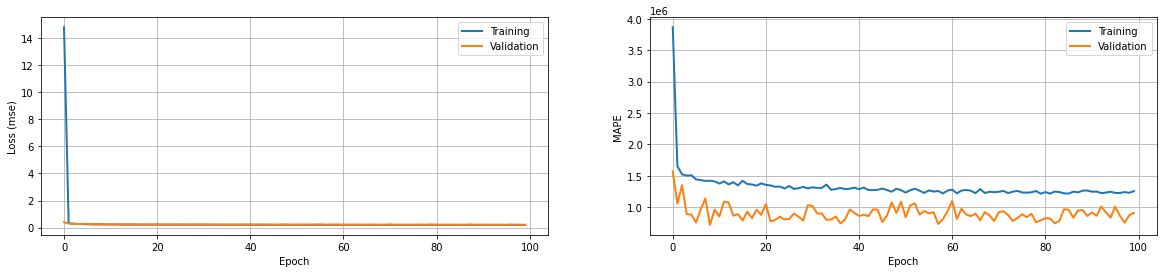

In [ ]:
# Plot loss
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(DNN.history.history['loss'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (mse)')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(DNN.history.history['mape'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_mape'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.grid()
plt.show()

In [ ]:
# Compute test loss
loss_test = DNN.evaluate(x=x_test, y=y_test, verbose=False)
print("Test loss and MAPE:", loss_test)

Test loss and MAPE: [0.21122857928276062, 1183173.0]


In [ ]:
# Predict on test set
y_test_hat = DNN.predict(x=x_test)
print(y_test_hat.shape)

100/100 [==============================] - 0s 1ms/step
(3182, 2)


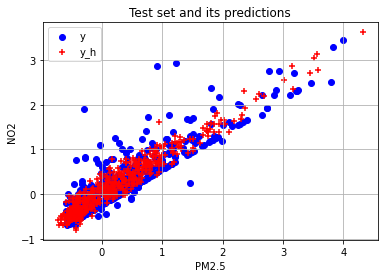

In [ ]:
# Plot y_test_hat
indx = np.random.permutation(len(y_test))[:500]
plt.scatter(y_test[indx, 0], y_test[indx, 1], c='b', label='y')
plt.scatter(y_test_hat[indx, 0], y_test_hat[indx, 1], c='r', marker='+', label='y_h')

plt.legend()
plt.grid(True)
plt.xlabel('PM2.5')
plt.ylabel('NO2')
plt.title('Test set and its predictions')
plt.show()

# Part 4: save model to disk and load ti back

In [ ]:
# Save model to disk, then delete it
DNN.save("my_DNN_model.h5")

del DNN

In [ ]:
# Load model back into memory, and use it for prediction
from tensorflow.keras.models import load_model
DNN = load_model("my_DNN_model.h5")

y_test_hat = DNN.predict(x=x_test)
print(y_test_hat.shape)

100/100 [==============================] - 0s 1ms/step
(3182, 2)
